In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from model import wrn_28_2
import torch
from tqdm import tqdm
import torch.nn.functional as F
from ema import EMA,EMADriver, set_ema_model
from train import trainer
from eval import predict, eval
from tqdm import tqdm
from semilearn import get_dataset, get_data_loader, get_net_builder, get_algorithm, get_config, Trainer
from semilearn.datasets.cv_datasets import get_cifar
import argparse
from semilearn.core.utils import get_dataset, get_data_loader, get_optimizer, get_cosine_schedule_with_warmup
import matplotlib.pyplot as plt
from flexmatch import FlexMatch

/opt/conda/envs/usb/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# config = {
#     'algorithm': 'fixmatch',
#     'net': 'wrn_28_2',
#     'use_pretrain': False,  # todo: add pretrain
#     'pretrain_path': None,

#     # optimization configs
#     'epoch': 3,
#     'num_train_iter': 150,
#     'num_eval_iter': 50,
#     'optim': 'SGD',
#     'lr': 0.03,
#     'momentum': 0.9,
#     'batch_size': 32,
#     'eval_batch_size': 64,

#     # dataset configs
#     'dataset': 'cifar10',
#     'num_labels': 40,
#     'num_classes': 10,
#     'img_size': 32,
#     'crop_ratio': 0.875,
#     'data_dir': './data',

#     # algorithm specific configs
#     'hard_label': True,
#     'uratio': 3,
#     'ulb_loss_ratio': 1.0,

#     # device configs
#     'gpu': 0,
#     'world_size': 1,
#     'distributed': False,
# }
# config = get_config(config)
# vars(config)
# dataset_dict = get_dataset(config, config.algorithm, config.dataset, config.num_labels, config.num_classes, data_dir=config.data_dir)
# train_lb_loader = get_data_loader(config, dataset_dict['train_lb'], config.batch_size)

In [4]:
device = torch.device('cuda:0')

m = wrn_28_2(pretrained=False,pretrained_path=None ,num_classes=10)
_=m.to(device)
ema = wrn_28_2(pretrained=False,pretrained_path=None ,num_classes=10)
ema = set_ema_model(ema, m)
emaA = EMADriver(model=m,ema_model=ema,ema_m=0.999)
# emaA = EMADriver(model=m,ema_model=ema,ema_m=0.999)
emaA.before_run()
args_d = {'dataset': 'cifar10',
         'num_classes': 10,
         'train_sampler': 'RandomSampler',
         'num_workers': 8,
         'lb_imb_ratio': 1,
         'ulb_imb_ratio':1.0,
          'batch_size': 32,
         'ulb_num_labels': 150,
         'img_size': 32,
         'crop_ratio': 0.875,
         'num_labels': 30,
         'seed': 1,
         'epoch': 3,
         'num_train_iter':150,
         'net': 'wrn_28_8',
         'optim': 'SGD',
         'lr': 0.03,
         'momentum': 0.9,
         'weight_decay': 0.0005,
         'layer_decay': 0.75,
          'num_warmup_iter': 0,
         'algorithm': 'fixmatch',
         'data_dir': './data',
         'uratio': 3,
         'eval_batch_size': 64}

parser = argparse.ArgumentParser(description='Semi-Supervised Learning (USB semilearn package)')
args = parser.parse_args("")
# args
for k in args_d:
        setattr(args, k, args_d[k])
# lb_dset, ulb_dset, eval_dset = get_cifar(args,
#           alg=None, 
#           name='cifar10',
#           num_labels=4000,
#           num_classes=10,
#           data_dir='./data',
#           include_lb_to_ulb=True)
dataset_dict = get_dataset(args, 
                           args.algorithm, 
                           args.dataset, 
                           args.num_labels, 
                           args.num_classes, 
                           data_dir=args.data_dir,
                          include_lb_to_ulb=False)
train_lb_loader = get_data_loader(args, dataset_dict['train_lb'], args.batch_size)
train_lb_loader = get_data_loader(args, dataset_dict['train_lb'], args.batch_size)
train_ulb_loader = get_data_loader(args, dataset_dict['train_ulb'], int(args.batch_size * args.uratio))
eval_loader = get_data_loader(args, dataset_dict['eval'], args.eval_batch_size)

optimizer = get_optimizer(m, args.optim, args.lr, args.momentum, args.weight_decay, args.layer_decay)
scheduler = get_cosine_schedule_with_warmup(optimizer,
                                            args.num_train_iter,
                                            num_warmup_steps=args.num_warmup_iter)
loss_ce = torch.nn.CrossEntropyLoss()

Files already downloaded and verified
lb count: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
ulb count: [15, 15, 15, 15, 15, 15, 15, 15, 15, 15]
Files already downloaded and verified


In [5]:


# m.train()
# ema.train()


steps,losses=trainer(train_lb_loader,
                     m,
                     emaA,
                     loss_ce,
                     scheduler, 
                     optimizer,
                     train_ulb_loader,
                     device,epochs=10)
    

100%|██████████| 10/10 [00:58<00:00,  5.83s/it]


In [6]:
# !python -m torch.utils.collect_env

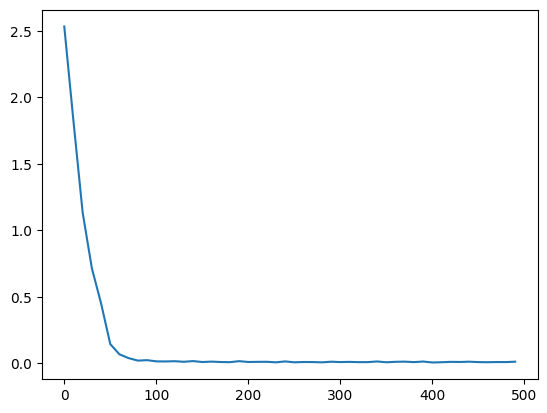

In [7]:
plt.plot(steps,losses)

In [8]:
# import torch.nn.functional as F

In [9]:
print(device)

cuda:0


In [10]:
import numpy as np

In [11]:
y_pred, y_logits, y_true, total_loss = predict(m,emaA.ema,eval_loader,device,return_gt=True,use_ema_model=False)

100%|██████████| 50/50 [00:01<00:00, 25.46it/s]


In [12]:
## Metrics

In [13]:
# y_true = data_lb['y_lb']
# y_pred = data_lb['y_lb']
print(total_loss)


6.822980442047119


In [14]:
top1,balanced_top1, precision, recall, F1, cf_mat  = eval(m,emaA.ema,eval_loader,device,return_gt=True,use_ema_model=False)
top1,balanced_top1, precision, recall, F1, cf_mat
no_ema = {
    'top1':top1,
    'balanced_top1':balanced_top1,
    'precision':precision,
    'recall':recall,
    'F1':F1,
    'cf_mat':cf_mat
}

100%|██████████| 50/50 [00:01<00:00, 25.45it/s]


In [15]:
# EMA

In [16]:
top1,balanced_top1, precision, recall, F1, cf_mat  = eval(m,emaA.ema,eval_loader,device,return_gt=True,use_ema_model=True)
ema_res = {
    'top1':top1,
    'balanced_top1':balanced_top1,
    'precision':precision,
    'recall':recall,
    'F1':F1,
    'cf_mat':cf_mat
}

100%|██████████| 50/50 [00:01<00:00, 25.44it/s]
/opt/conda/envs/usb/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
# top1,balanced_top1, precision, recall, F1, cf_mat

top1 0.14 0.14125


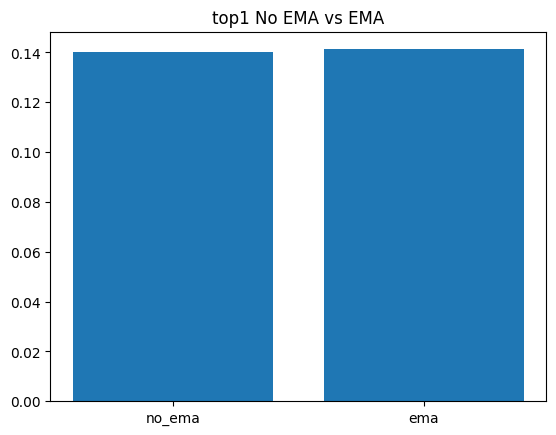

balanced_top1 0.13929979622281946 0.14216215801599402


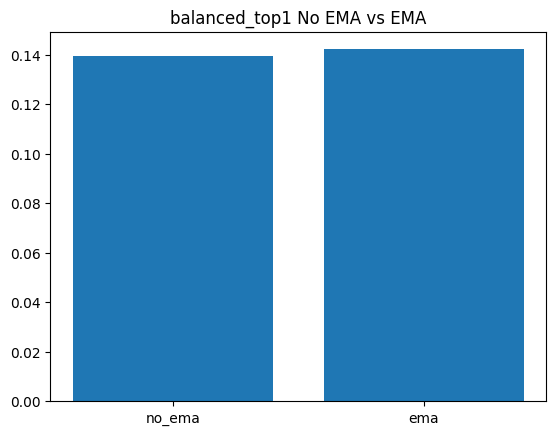

precision 0.17304718770643665 0.08463074301450797


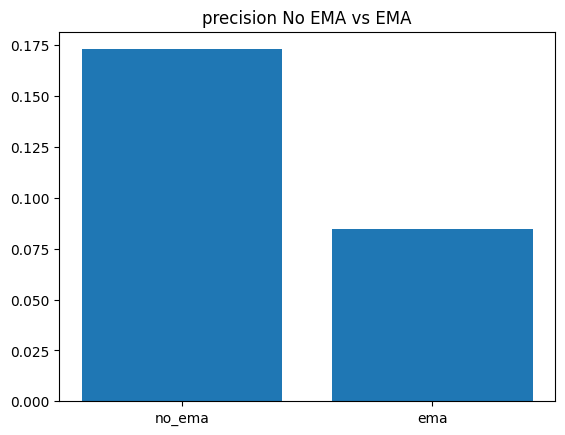

recall 0.13929979622281946 0.14216215801599402


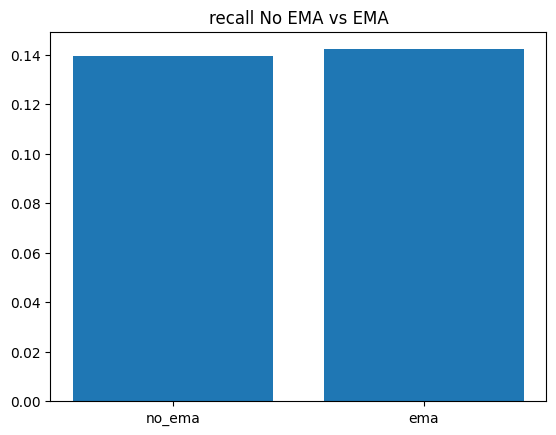

F1 0.08576444671887935 0.07154295006461477


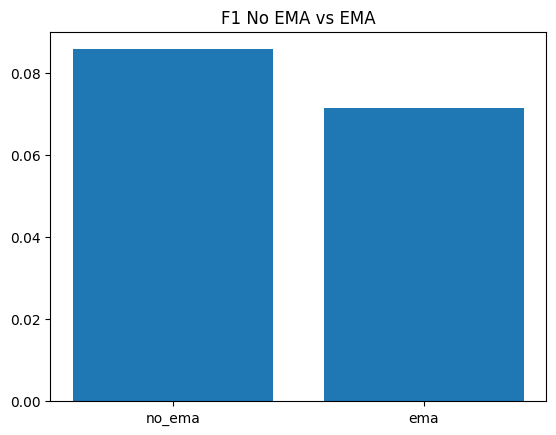

In [18]:
for k in ema_res.keys():
    if k!='cf_mat':
        print(k,no_ema[k],ema_res[k])
        plt.bar(['no_ema','ema'],[no_ema[k],ema_res[k]])
        plt.title("{} No EMA vs EMA".format(k))
        plt.show()

In [19]:
# Misc

In [20]:
from flexmatch import PseudoLabelingHook

In [21]:
p = PseudoLabelingHook()

In [22]:
import torch

In [23]:
import math
math.exp(math.log(1/90.))

0.011111111111111112

In [24]:
# logit_test = torch.Tensor([0.9,1/90.,1/90.,1/90.,1/90.,1/90.,1/90.,1/90.,1/90.,1/90.])
# logit_test = torch.Tensor([math.log(0.9),
#                            math.log(1/90.),
#                            math.log(1/90.),
#                            math.log(1/90.),
#                            math.log(1/90.),
#                            math.log(1/90.),
#                            math.log(1/90.),
#                            math.log(1/90.),
#                            math.log(1/90.),
#                            math.log(1/90.)]).reshape(1,-1)# Need to be at least 2 dimensional
logit_test = torch.Tensor([math.log(0.9),
                           math.log(0.1)]).reshape(1,-1)# Need to be at least 2 dimensional
logit_test.shape

torch.Size([1, 2])

In [25]:
math.log(0.9)

-0.10536051565782628

In [26]:
math.log(0.1)

-2.3025850929940455

In [27]:
math.log(1/90.)

-4.499809670330265

In [28]:
math.log(0.1/2.)


-2.995732273553991

In [29]:
torch.softmax(logit_test,dim=-1)

tensor([[0.9000, 0.1000]])

In [30]:
print(logit_test)
p.gen_ulb_targets(logits=logit_test,
                  use_hard_label=True, 
                  T=1.0,
                  softmax=True, # whether to compute softmax for logits, input must be logits
                  label_smoothing=0.01)

tensor([[-0.1054, -2.3026]])


tensor([[0.9900, 0.0100]])

In [31]:
res = p.gen_ulb_targets(logits=logit_test,
                  use_hard_label=False, 
                  T=math.log(0.9),
                  softmax=True, # whether to compute softmax for logits, input must be logits
                  label_smoothing=0.01)
for i in res[0]:
    print(i)

tensor(8.7715e-10)
tensor(1.)


In [32]:
# Flexmatch masking

In [33]:
for ind,(data_lb, data_ulb) in enumerate(zip(train_lb_loader, train_ulb_loader)):
    print(data_ulb.keys())
    idx_ulb = data_ulb['idx_ulb'].to(device)
    x_ulb_w = data_ulb['x_ulb_w'].to(device)
    x_ulb_s = data_ulb['x_ulb_s'].to(device)
    with torch.no_grad():
        out = m(x_ulb_w)
        out = out['logits']
    # print(idx_ulb)
    print(x_ulb_w.shape)
    print(x_ulb_s.shape)
    if ind>3:
        break

dict_keys(['idx_ulb', 'x_ulb_w', 'x_ulb_s'])
torch.Size([96, 3, 32, 32])
torch.Size([96, 3, 32, 32])
dict_keys(['idx_ulb', 'x_ulb_w', 'x_ulb_s'])
torch.Size([96, 3, 32, 32])
torch.Size([96, 3, 32, 32])
dict_keys(['idx_ulb', 'x_ulb_w', 'x_ulb_s'])
torch.Size([96, 3, 32, 32])
torch.Size([96, 3, 32, 32])
dict_keys(['idx_ulb', 'x_ulb_w', 'x_ulb_s'])
torch.Size([96, 3, 32, 32])
torch.Size([96, 3, 32, 32])
dict_keys(['idx_ulb', 'x_ulb_w', 'x_ulb_s'])
torch.Size([96, 3, 32, 32])
torch.Size([96, 3, 32, 32])


In [34]:
from flexmatch import FlexMatchThresholdingHook

In [35]:
T=0.5
thresh_warmup=True
p_cutoff=0.95
t = FlexMatchThresholdingHook(ulb_dest_len=len(dataset_dict['train_ulb']),
                              T=T,
                              p_cutoff=p_cutoff,
                              num_classes=10,
                              thresh_warmup=thresh_warmup)

In [36]:
# t.p_cutoff

In [37]:
t.masking( out, idx_ulb, softmax_x_ulb=True)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.], device='cuda:0')

In [38]:
len(dataset_dict['train_ulb'])

150

In [39]:
#FlexMatch

In [40]:
# ema

In [42]:
# f = FlexMatch(T, 
#              p_cutoff, 
#              ulb_dest_len=len(dataset_dict['train_ulb']),
#              num_classes=10,
#              model=m)
del m
del ema
del emaA
m = wrn_28_2(pretrained=False,pretrained_path=None ,num_classes=10)
_=m.to(device)
ema = wrn_28_2(pretrained=False,pretrained_path=None ,num_classes=10)
ema = set_ema_model(ema, m)
emaA = EMADriver(model=m,ema_model=ema,ema_m=0.999)
# emaA = EMADriver(model=m,ema_model=ema,ema_m=0.999)
emaA.before_run()

f = FlexMatch(T=1.0, 
             p_cutoff=0.95, 
             ulb_dest_len=len(dataset_dict['train_ulb']),
             num_classes=10,
             model=m,
             ema_model=ema,
             loss_ce=loss_ce,
             scheduler=scheduler,
             optimizer=optimizer,
             device=device,
             train_lb_loader=train_lb_loader,
             train_ulb_loader=train_ulb_loader,
             ulb_loss_ratio=1.0,
             hard_label=True, 
             thresh_warmup=True)

In [43]:
# f.train_step()

In [44]:
# for ind,(data_lb, data_ulb) in enumerate(zip(train_lb_loader, train_ulb_loader)):
#     print(data_lb.keys())
#     idx_lb = data_lb['idx_lb'].to(device)
#     x_lb = data_lb['x_lb'].to(device)
#     y_lb = data_lb['y_lb'].to(device)
#     idx_ulb = data_ulb['idx_ulb'].to(device)
#     x_ulb_w = data_ulb['x_ulb_w'].to(device)
#     x_ulb_s = data_ulb['x_ulb_s'].to(device)
#     loss = f.train_step( x_lb, y_lb, idx_ulb, x_ulb_w, x_ulb_s)
#     print(loss)
#     break

In [45]:
steps, sup_loss,unsup_loss,total_loss = f.fit()

100%|██████████| 10/10 [04:32<00:00, 27.28s/it]


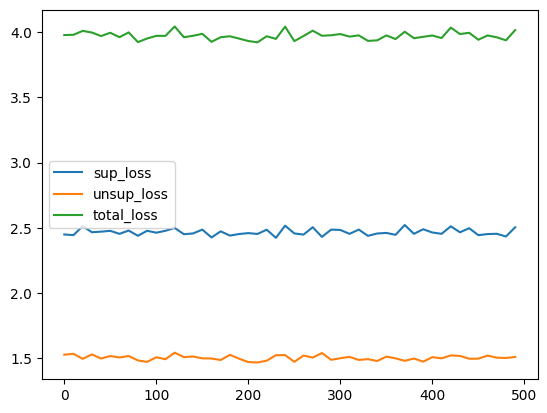

In [48]:
plt.plot(steps,sup_loss)
plt.plot(steps,unsup_loss)
plt.plot(steps,total_loss)
plt.legend(['sup_loss','unsup_loss','total_loss'])
plt.show()

100%|██████████| 50/50 [00:01<00:00, 25.02it/s]
/opt/conda/envs/usb/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 50/50 [00:01<00:00, 25.31it/s]
/opt/conda/envs/usb/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


top1 0.1034375 0.1034375


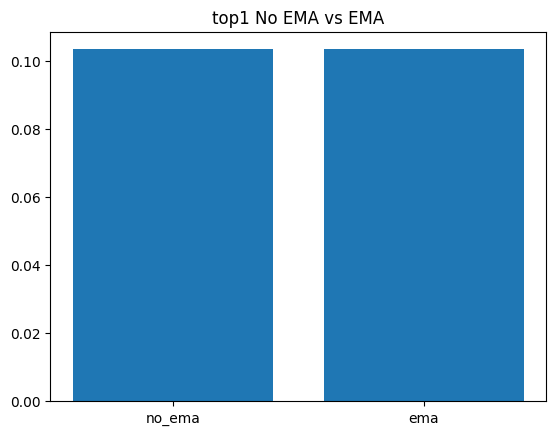

balanced_top1 0.09795262491256593 0.09795262491256593


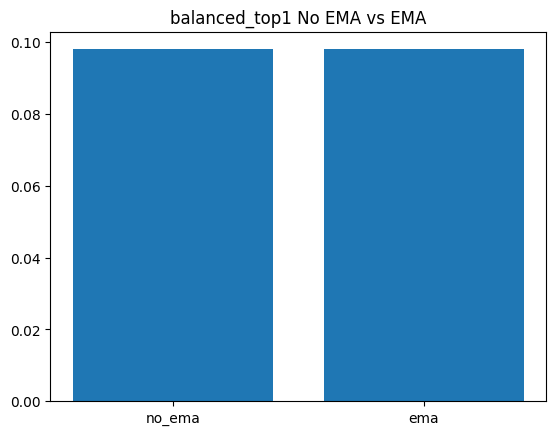

precision 0.06041337961502051 0.06041337961502051


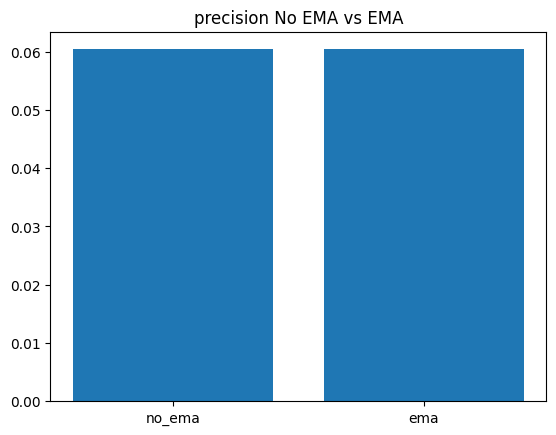

recall 0.09795262491256593 0.09795262491256593


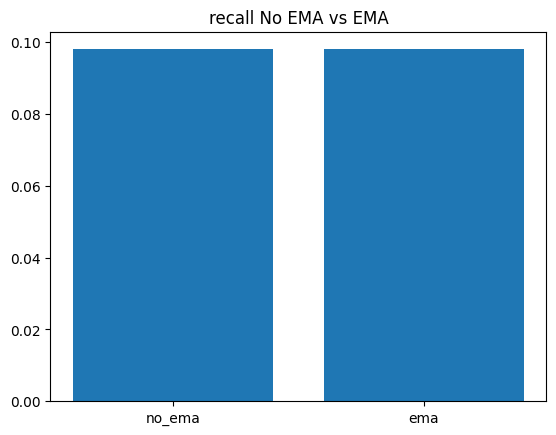

F1 0.01945442448436461 0.01945442448436461


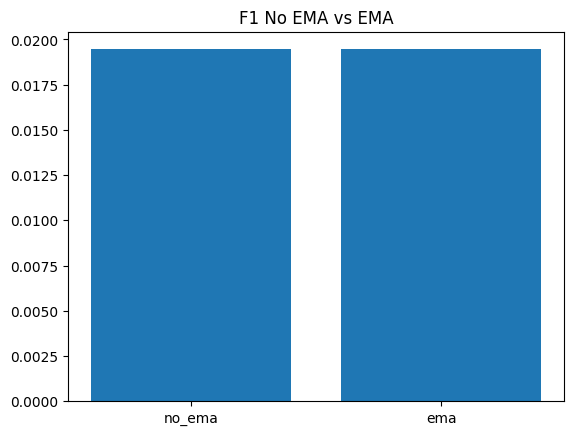

In [47]:
top1,balanced_top1, precision, recall, F1, cf_mat  = eval(m,emaA.ema,eval_loader,device,return_gt=True,use_ema_model=False)
no_ema = {
    'top1':top1,
    'balanced_top1':balanced_top1,
    'precision':precision,
    'recall':recall,
    'F1':F1,
    'cf_mat':cf_mat
}
top1,balanced_top1, precision, recall, F1, cf_mat  = eval(m,emaA.ema,eval_loader,device,return_gt=True,use_ema_model=True)
ema_res = {
    'top1':top1,
    'balanced_top1':balanced_top1,
    'precision':precision,
    'recall':recall,
    'F1':F1,
    'cf_mat':cf_mat
}
for k in ema_res.keys():
    if k!='cf_mat':
        print(k,no_ema[k],ema_res[k])
        plt.bar(['no_ema','ema'],[no_ema[k],ema_res[k]])
        plt.title("{} No EMA vs EMA".format(k))
        plt.show()

In [ ]:
# ema_res